For convenience, we can increase the display width of the Notebook to make better use of widescreen format

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Next, we will import all the libraries that we need.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from scipy.io import wavfile
import python_speech_features
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from livelossplot import PlotLossesKeras
import sounddevice as sd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import butter, sosfilt
from timeit import default_timer as timer
from IPython.display import clear_output

The Google Speech Command Dataset which we'll be using contains 30 different words, 20 core words and 10 auxiliary words. In this project we'll be using only the 20 core words.


We can define ourselves a dictionary that maps each different word to a number and a list that does the inverse mapping. This is necessary because we need numerical class labels for our Neural Network.

In [3]:
word2index = {
    # core words
    "yes": 0,
    "no": 1,
    "up": 2,
    "down": 3,
    "left": 4,
    "right": 5,
    "on": 6,
    "off": 7,
    "stop": 8,
    "go": 9,
    "zero": 10,
    "one": 11,
    "two": 12,
    "three": 13,
    "four": 14,
    "five": 15,
    "six": 16,
    "seven": 17,
    "eight": 18,
    "nine": 19,
}

index2word = [word for word in word2index]

Next, we will go trough the dataset and save all the paths to the data samples in a list.

You can download the Google Speech Commands dataset [here](http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz) (1.4 GB!)
and decompress it (e.g. with 7zip). Define the path where you stored the decommpressed dataset as *speech_commands_dataset_basepath*.

The dataset doesn't contain an equal number of samples for each word, but it contains >2000 valid samples for each of the 20 core words.
Each sample is supposed to  be exactly 1s long, which at a sampling rate of 16kHz and 16bit quantization should result in 32044 Byte large files.
Somehow some samples in the dataset are not exactly that size, we skip those.

Additionally we'll use a nice [tqdm](https://tqdm.github.io/) progress bar to make it more fancy. In the end, we should have gathered a total of 40000 samples.

In [17]:
num_classes = len(word2index)
num_samples_per_class = 2000
speech_commands_dataset_basepath = Path(r"C:\Users\tunin\Desktop\Marcel_Python\speech_command_dataset")

print("loading dataset...")
samples = []
classes =  []
with tqdm(total=num_samples_per_class*20) as pbar:
    for word_class in word2index:
        folder = speech_commands_dataset_basepath / word_class # sub-folder for each word
        count = 0
        for file in folder.iterdir(): # iterate over all files in the folder
            # somehow, there are samples which aren't exactly 1 s long in the dataset. ignore those
            if file.stat().st_size == 32044:
                samples.append(file) # store path of sample file
                classes.append(word2index[word_class]) # append word class index to list
                count +=1
                pbar.update()
            if count >= num_samples_per_class:
                break
classes = np.array(classes, dtype=np.int)

loading dataset...


Next we'll define two functions to compute some [features](https://en.wikipedia.org/wiki/Feature_(machine_learning)) of the audio samples and another function which loads the sample wav-file and then computes the features. Before computing features, it is a good idea to normalize our input data. Depending on your recording device and other parameters, the amplitudes of the recorded audio signals may vary drastically and might even have an offset. Thus we can subtract the mean value to remove the offset and divide by the absolute maximum value of the signal, so that it's new range lies between -1.0 and +1.0.

In this case, we'll use the so called "Mel-Frequency Cepstrum Coefficients", which are very commonly used for speech recognition tasks. The MFCCs are computed as follows:

* Apply a simple pre-emphasis filter to the signal, to emphasize higher frequencies (optional):
  
  $y_t \leftarrow y_t - \alpha \cdot y_{t-1} \hspace{1mm} , \hspace{2mm} t=1...T$
  
  
  
*  Extract snippets from the audio signal. A good choice for the length of the snippets is 25ms. The stride between snippets is 10ms, so the snippets will overlap. To "cut" the snippets from the audio signal, a window like the Hamming window is appropriate to mitigate the leakage effect when performing the Fourier Transform in the next step.


* Calculate the FFT of the signal and then the power spectrum, i.e. the squared magnitude of the spectrum for each snippet.


* Apply a Mel filterbank to the power spectrum of each snippet. The [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a scale, that takes into account the fact, that in human auditory perception, the perceivable pitch (i.e. frequency) changes decrease with higher frequencies. This means e.g. that we can distinguish much better between a 200Hz and 300Hz tone than between a 10200 Hz and a 10300 Hz tone even though the absolute difference is the same.

  The filterbank consists of $N=40$ triangular filters evenly spaced in the Mel scale (and nonlinearly spaced in frequency scale). These filters are multiplied with the power spectrum, which gives us the sum of "energies" in each filter. Additionally, we take the log() of these energies.


* The log-energies of adjacent filters usually correlate strongly. Therefore, a [Discrete Cosine Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform) is applied to the log filterbank energies of each snippet. The resulting values are called *Cepstral coefficients*. The zeroth coefficient represents the average log-energy in each snippet, it may or may not be discarded (here we'll keep it as a feature). Usually, only a subset, e.g. the first 8-12 Cepstral coefficients are used (here we'll use 20), the rest are discarded 

For more details about MFCC, a good source is:  
*pp. 85-72 in K.S. Rao and Manjunath K.E., "Speech Recognition Using Articulatory and Excitation Source Features", 2017, Springer*  
(pp. 85-92 available for preview at [https://link.springer.com/content/pdf/bbm%3A978-3-319-49220-9%2F1.pdf])


Thankfully we don't have to implement the MFCC computation ourselves, we'll use the library [python_speech_features](https://python-speech-features.readthedocs.io/en/latest/).

In [4]:
# compute MFCC features from audio signal
def audio2feature(audio):
    audio = audio.astype(np.float)
    # normalize data
    audio -= audio.mean()
    audio /= np.max((audio.max(), -audio.min()))
    # compute MFCC coefficients
    features = python_speech_features.mfcc(audio, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

# load .wav-file, add some noise and compute MFCC features
def wav2feature(filepath):
    samplerate, data = wavfile.read(filepath)
    data = data.astype(np.float)
    # normalize data
    data -= data.mean()
    data /= np.max((data.max(), -data.min()))
    # add gaussian noise
    data += np.random.normal(loc=0.0, scale=0.025, size=data.shape)
    # compute MFCC coefficients
    features = python_speech_features.mfcc(data, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

If we compute the features for one audio sample, we see that the feature shape is (99, 20). The first index is that of the 10ms long snippet of the 1s long audio signal, so we have 1s/10ms-1=99 snippets. The second dimension is the number of MFC coefficients, in this case we have 20.

Now we can load all audio samples and pre-compute the MFCC features for each sample. Note that this will take quite a long time!

In [18]:
feature_shape = wav2feature(samples[0]).shape
features = np.empty((num_classes*num_samples_per_class, )+(feature_shape), dtype=np.float)
print("features.shape", features.shape)

print("pre-computing features from audio files...")
with tqdm(total=num_samples_per_class*num_classes) as pbar:
    for k, sample in enumerate(samples):
        features[k] = wav2feature(sample)
        pbar.update()

features.shape (40000, 99, 20)
pre-computing features from audio files...


Now we can save the pre-computed training dataset containing the features of the training samples and their class labels.  
This way, we won't have to re-compute the features next time.

In [23]:
# save computed features and classes to hard drive
np.save("mfcc_plus_energy_features_40000x99x20", features)
np.save("classes", np.array(classes, dtype=np.int))

We can load the pre-computed features and class labels as follows:

In [5]:
# load pre-computed training features dataset and training class labels
features = np.load("mfcc_plus_energy_features_40000x99x20.npy")
classes = np.load("classes.npy")

Now the next thing to do is divide our dataset into a training dataset and a validation dataset.  
The training dataset is used for training our Neural Network, i.e. the Neural Network will learn to correctly predict a sample's class label based on it's features.

One problem that can occur in Machine Learning is so called *Overfitting*. Our basic goal is to train our Neural Network so that it does not only classify the training samples correctly, but also new samples, which it has never "seen" before. This is called *Generalization*. But with complex networks it can happen that instead of really learning to classify samples based on their features, the network simply "learns by heart" to which class each training sample belongs. This is called Overfitting. In this case, the network will perform great on the training data, but poorly on new previously unseen data.

One method to mitigate, is the use of a separate validation dataset. So we split the whole dataset, and use a small subset (e.g. here one third of the data) for validation, the rest is our training set.  
Now during training, only the training dataset will be used to calculate the weigths of the Neural Network (which is the "learning" part). After each epoch (i.e. once all training samples have been considered once), we will tell the network to try and predict the class labels of all samples in our validation dataset and based on that, calculate the accuracy on the validation set.

So during training, after each training epoch, we can look at the accuracy of the network on the training set and on the validation set.  
At the beginning of the training, both accuracies will typically improve. At one point we might see that the validation accuracy plateaus or evendecreases, while the training accuracy still improves. This indicates that the network is starting to overfit, thus it is a good time to stop the training.

Another method to mitigate overfitting is the use of so called [Dropout-Layers](https://en.wikipedia.org/wiki/Dilution_(neural_networks)) which randomly set a subset of the weigths of a layer to zero. In this project, we won't use them.

In [8]:
train_data, validation_data, train_classes, validation_classes = train_test_split(features, classes,
                                                                      test_size=0.30, random_state=42, shuffle=True)

The next step is to define our Neural Network's architecture. The network can be described by a sequence of layers.  

For this task we will implement a [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network). The two main characteristics of CNNs are convolutional layers and pooling layers.

Convolutional layers convolve a filter vector (1D) or matrix (2D) with the input data. The main advantage of convolutional layers (and thus of CNNs) is, that they can achieve a high degree of shift-/translation-invariance. Picture the following example: we have two 2s long recordings of the same spoken word, but in one recording the word is right at the beginning of the recording, and in the other one at the end. Now a conventional Neural Network might have a hard time learning to recognize the words, because it expects certain features at certain position in time. Another example migth be an image classifier that recognizes objects well if they're all in the center of the image and in the same orientation, but fails if the objects are in a corner of the image or rotated. So we want the network to be invariant to translations and rotations of the features, i.e. recognize features regardless of their position in time (e.g. in case of audio) or space (e.g. in case of an image).  

A convolutional layer needs 3 parameters:
* filter size $F$: width (1D) or height and width (2D) of filter vector/matrix. Determines number of weigths of the layer.
* stride $S$: determines the step size with which we move the filter across the signal or image
* padding $P$: pad the input data with zeros  
The size of the convolutional layer's output is:  
# $W_{out}=\frac{W_{in}-F-2P}{S}+1$  

In Keras, the default stride is one and the default padding is zero.

A pooling layer is somewhat similar in that it also convolves a "filter"-vector/matrix across the input with a certain stride and possibly padding. But instead of multiplying the input values with the filter values, the pooling layer computes either the average or maximum value of the values. Max-pooling layers are commonly used, average pooling rarely. So e.g. a 3x3 max-pooling layer will slide a 3x3-filter over the input and deliver the maximum of the 3*3=9 values as output. In contrary to the convolutional layer, a pooling layer introduces no additional weights. The output size of a pooling layer can be calculated with the same formula as for the convolutional layer.  
In Keras, the default stride is equal to the filter size and the default padding is zero. In this case the formula simplifies to:
# $W_{out}=\frac{W_{in}-F-2P}{S}+1=\frac{W_{in}-F}{F}+1=\frac{W_{in}}{F}$  
A max-pooling layer achieves a down-sampling of the feature vector/matrix and also a translation/shift-invariance of the features. It is common to use a pooling layer after a convolution layer. 


We'll be creating our CNN model using keras' [Sequential](https://keras.io/guides/sequential_model/) model.  
At first, we add an input layer whose input size matches the dimensions of our MFCC features. In this case wee have 20 MFC coefficients and 99 timeframes, thus the feature matrix for an audio sample is of size (99, 20). In Keras, the input shapes are by default as follows:
* (batch, axis, channel): one-dimensional data with $\geq$1 channels. This most commonly represents a timeseries, i.e. a number of features that change over time.  
  In our case, the (99, 20) feature matrix is interpreted as a time series (i.e. axis represents time(-frame)) with 20 channels (the MFC coefficients. We can perform a 1D-convolution on such data.
* (batch, axis0, axis1, channel): two-dimensional data with $\geq$1 channels. This is most often a color image, where axis0 and axis1 are the horizontal and vertical position of an image pixel and each pixel has 3 channels for the red, green and blue color values. We can perform a 2D-convolution on such data.
* (batch, axis0, axis1, ..., axisN-1, channel): n-dimensional data with $\geq$1 channels.


Now you may wonder about the batch dimension. This is another dimension that specifies the number of samples, because during training we often load batches of more than one sample in one iteration to average the gradients during optimization. In Keras, during model specification the batch dimension is ignored, so we won't have to specify it explicitly. But as you can see, our *features* variable, which contains all training samples has the shape (40000, 99, 20), so its first axis is the batch dimension. This way when we'll later pass the training data to the *fit()*-function, it can fetch a batch, i.e. a subset of the dataset for each training iteration.

Next, we add a 1-D convolutional layer ([Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/)). This layer performs a one dimensional convolution along the (in our case) time (or more precisely timeframe) axis. The first argument is the number of filters to apply. Most often we use many filters, thus performing the convolution multiple times with different filter kernels. This way, the number of channels of the convolutional layer's output is the number of filters used. The second argument is the kernel size, this is the size of our convolution filter. At last, we specify an activation function used, in this case the ReLU-function is used.  
After the first convolutional layer, we add a max pooling layer with a size of 3 that reduces the data size along the time axis. Note that in case the division is fractional, the resulting size will be the floor value.


Such a combination of convolutional layer and pooling layer is very common in CNNs. The main idea is to repeatedly stack convolution and pooling layers, so that the dimension (in time or space) of the input data is subsequently reduced, while the feature space dimensionality (i.e. number of channels) increases. 

Next, we add two more stacks of convolutional and max pooling layer. For the last pooling layer, we use a global pooling layer, which behaves just like the normal pooling layer, but with a filter that spans the whole axis size. After the global max pooling operation, our data is one-dimensional, with the time axis completely removed and only the feature dimension remaining.

In the next step, we add a couple of fully connected (Keras calles them "dense") layers, just like in a regular Multi Layer Perceptron (MLP). Each layer reduces the feature dimensionality, so that the last layer has an output dimension equal to the number of different classes (in our case words). Using the Softmax activation function on the last dense layer, we can interpret the networks output as an a posteriori probability distribution of the sample belonging to a certain class, given the audio sample's input features.

In [25]:
keras.backend.clear_session() # clear previous model (if cell is executed more than once)

### CNN MODEL DEFINITION ###
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(99, 20)))

model.add(keras.layers.Conv1D(64, kernel_size=8, activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=3))

model.add(keras.layers.Conv1D(128, kernel_size=8, activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=3))

model.add(keras.layers.Conv1D(256, kernel_size=5, activation="relu"))
model.add(keras.layers.GlobalMaxPooling1D())

model.add(keras.layers.Dense(128, activation="relu"))

model.add(keras.layers.Dense(64, activation="relu"))

model.add(keras.layers.Dense(num_classes, activation='softmax'))

# print model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 92, 64)            10304     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 128)           65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 256)            164096    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

Now that our CNN model is defined, we can configure it for training. Therefore we choose an optimization algorithm, e.g. Stochastic Gradient Descent (SGD) or ADAM. Additionally, we need to specify a loss function for training. The loss function determines, how the performance of the network is evaluated. In this case, we have a multi-class classification problem, where the class labels are represented as integer values. In this case, the sparse categorical cross-entropy loss can be used. If our class labels were encoded using a one-hot encoding scheme, we would use the normal (non-sparse) variant. As a metric we specify the accuracy so that after every epoch, the accuracy of the network is computed.

In [26]:
sgd = keras.optimizers.SGD()
loss_fn = keras.losses.SparseCategoricalCrossentropy() # use Sparse because classes are represented as integers not as one-hot encoding

model.compile(optimizer=sgd, loss=loss_fn, metrics=["accuracy"])

Before starting the training, it can be useful to define an early stopping criterion in order to avoid overfitting as explained previously. We define a callback function which checks if the accuracy on the validation set has increased in the last 5 epochs and stops training if this is not the case. After stopping, the model is reverted to the state (i.e. the weigths) which had achieved the best result.  

We'll also use the [livelossplot](https://github.com/stared/livelossplot) library, which provides functions to plot a live graph of the accuracy and loss metrics during training. We pass the plot function as a callback too.

Finally, we can start training using *model.fit()*. We specify the training and validation dataset, the max number of epochs to train, the callbacks and the batch size. In this case, a batch size of 32 is used, so that in every iteration, a batch of 32 samples is used to compute the gradient. Especially when using SGD, the batch size influences the training. In each iteration, the average of the gradients for the batch is computed and used to update the weights. A smaller batch leads to a "noisy" gradient which can be good to explore the weigth space further (and not get stuck very early in  a local minimum), but affects convergence towards the end of training negatively. A larger batch leads to less noisy gradients, so that larger steps can be made (i.e. a higher learning-rate) which lead to faster training. Additionally, larger batches tend to reduce computation overhead. A batch size of one would be "pure" stochastic gradient descent, while a batch equal to the whole training set would be considered standard (i.e. non-stochastic) gradient descent. With a batch size in between (often called "mini batch"), a good compromise can be found.  

Sidenote: It seems that matplotlib's *notebook* mode (which is for use in Jupyter Notebooks) doesn't work well with the live plotting, so we use *inline* mode.

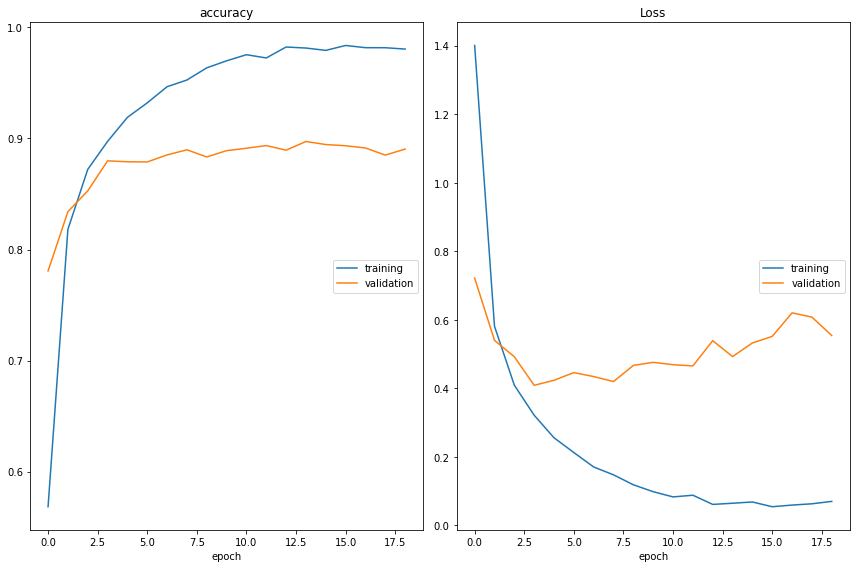

accuracy
	training         	 (min:    0.568, max:    0.984, cur:    0.980)
	validation       	 (min:    0.781, max:    0.897, cur:    0.890)
Loss
	training         	 (min:    0.055, max:    1.400, cur:    0.070)
	validation       	 (min:    0.409, max:    0.722, cur:    0.554)
875/875 [==============================] - 10s 12ms/step - loss: 0.0702 - accuracy: 0.9805 - val_loss: 0.5541 - val_accuracy: 0.8904


In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
plt.close()

history = model.fit(train_data, 
                    train_classes, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(validation_data, validation_classes),
                    callbacks=[PlotLossesKeras(), early_stopping])

As we can see, during the training, the losses decrease and the accuracy increases.
After training, we can save our model for later use if we want to.

In [6]:
# save model
model.save(datetime.now().strftime("%d_%m_%Y__%H_%M")+".h5")

In [ ]:
# load model
model = keras.models.load_model("05_08_2020__19_23.h5")

Another useful tool for evaluating a classifier's performance is a so called confusion matrix.
To compute the confusion matrix, we use our network to predict the class labels of all samples in the validation set.
The confusion matrix plots the probability with which a sample of a certain class is classified as belonging to a certain class. Thus, the values on the matrix' diagonal represent the correct classifications and those outside the diagonal the incorrect classifications. The matrix is thus by nanture symmetric.  

The interesting thing to see is that the confusion matrix allows us to see if a certain pair of class labels are often falsely classified, i.e. confused with each other. If two classes would often be confused (e.g. because two words sound very similar) we would find a high value outside the diagonal. For example, if we look closely at the matrix below, we can see a slightly larger value (darker color) at "go"-"no". This means that these two words are more often confused with eachother, which is plausible since they sound very similar. The ideal result would be a value of $\frac1N$ ($N$=number of classes) on the diagonals (assuming classes are equally represented in the dataset) and zeros everywhere outside the diagonal.

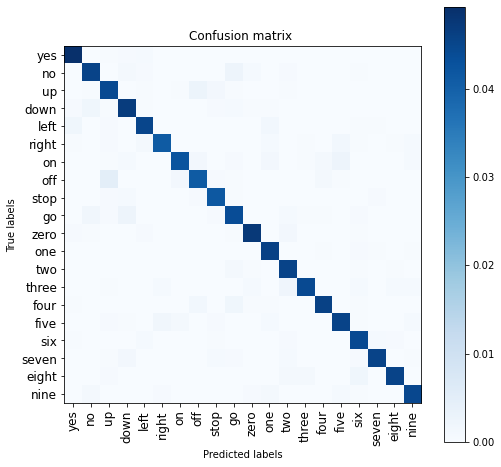

In [9]:
# plot confusion matrix
y = np.argmax(model.predict(validation_data), axis=1)
cm = confusion_matrix(validation_classes, y,  normalize="all")
%matplotlib inline
plt.close()
plt.figure(figsize = (8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(0, 20, 1), index2word, rotation=90)
plt.yticks(np.arange(0, 20, 1), index2word)
plt.tick_params(labelsize=12)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Ok, now we can try the keyword recognizer ourselves!  

To easily record and play audio, we'll use the library [sounddevice](https://python-sounddevice.readthedocs.io/en/0.4.0/index.html). One thing to consider is, that we have created our CNN model so that it accepts an input feature vector that corresponds to an audio snippet of exactly 1s length at 16kHz sampling rate, i.e. 16000 samples. So we could record for exactly 1s, but this is not very practical, as you would have to say the word just at the right time after starting the recording so that it lies within the 1s time window.  
A more elegant solution is to record for a longer duration, e.g. 3s and then extract a 1s long snippet which we can then feed to our CNN. For this simple case we'll assume that the user says only one word during the recording, so we extract the 1s long snippet of the recording which contains the maximum signal energy. This sounds complicated, but can be quite easily computed using a [convolution](https://en.wikipedia.org/wiki/Convolution). First, we compute the power signal by element-wise squaring the audio signal. Then we create a 1s (i.e. 16000 points) long rectangle window and convolve the power signal with the window. We use ["valid" mode](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) which means that only points where the signals overlap completely are computed (i.e. no zero-padding). This way, by computing the time at which the convolution is maximal, we get the starting time of the rectangle window which leads to maximal signal energy in the extracted snippet. We can then extract a 1s long snippet from the recording.


After defining a function to extract the 1s snippet, we configure the samplerate and device for recording. You can find out the number of the devices via *sd.query_devices()*. After recording for 3s and extracting the 1s snippet we can play it back. Then we compute the MFCC features and add a "fake" batch dimension to our sample before feeding it into our CNN mmodel for prediction. This is needed because the model expects batches of $\geq1$ samples as input, so since we have only one sample, we append a dimension to get a batch of one single sample. Additionally, we'll time the computation and model prediction to see how fast it is. We can normalize the CNN model's output to get a probability distribution (not strictly mathematical, but we can interpret it that way). Then we get the 3 candidates with highest probability and print the result. We'll also plot the raw audio signal and visulize the MFC coefficients.

In [10]:
def extract_loudest_section(audio, length):
    audio = audio[:, 0].astype(np.float) # to avoid integer overflow when squaring
    audio_pw = audio**2 # power
    window = np.ones((length, ))
    conv = np.convolve(audio_pw, window, mode="valid")
    begin_index = conv.argmax()
    return audio[begin_index:begin_index+length]

candidates:
-----------------------------
1.)	yes	:	99.8%
2.)	no	:	0.1%
3.)	left	:	0.0%
-----------------------------
feature computation time: 5.3 ms
CNN model prediction time: 92.4 ms
total time: 97.7 ms


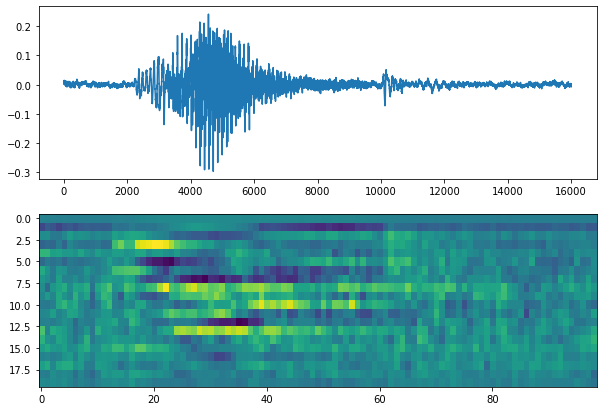

In [11]:
sd.default.samplerate = 16000
sd.default.channels = 1, 2 # mono record, stereo playback


recording = sd.rec(int(3*sd.default.samplerate), channels=1, samplerate=sd.default.samplerate, dtype=np.float, blocking=True)
recording = extract_loudest_section(recording, int(1*sd.default.samplerate)) # extract 1s snippet with highest energy (only necessary if recording is >3s long)
sd.play(recording, blocking=True)

t1 = timer()
recorded_feature = audio2feature(recording)
t2 = timer()
recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
prediction = model.predict(recorded_feature).reshape((20, ))
t3 = timer()
# normalize prediction output to get "probabilities"
prediction /= prediction.sum()

# print the 3 candidates with highest probability
prediction_sorted_indices = prediction.argsort()
print("candidates:\n-----------------------------")
for k in range(3):
    i = int(prediction_sorted_indices[-1-k])
    print("%d.)\t%s\t:\t%2.1f%%" % (k+1, index2word[i], prediction[i]*100))
print("-----------------------------")
print("feature computation time: %2.1f ms" % ((t2-t1)*1e3))
print("CNN model prediction time: %2.1f ms" % ((t3-t2)*1e3))
print("total time: %2.1f ms" % ((t3-t1)*1e3))

plt.close()
plt.figure(1, figsize=(10, 7))
plt.subplot(211)
plt.plot(recording)
plt.subplot(212)
plt.imshow(recorded_feature.reshape(99, 20).T, aspect="auto")
plt.show()

As we see in this case, the results look really good. If the probability for the best candidate is very high and those of the second-best and third-best candidates are pretty low, the prediction seems quite trustworthy.  
Additionally, we can see that the feauture computation and CNN model prediction are quite fast. The total execution time is around 100ms, which means that our method is quite able to work in "real-time".  

So now let's adapt and extend this little demo to work in real-time. For this, we'll use a buffer that contains 5 succeeding snippets of 3200 samples, i.e. 200ms each. We implement this audio buffer as a ringbuffer, which means that every time a new 200ms long snippet has been recorded, the oldest snippet in the buffer is discarded, the buffer is moved one step back and the newest snippet is put at the last position. This way, our buffer is updated every 200ms and always contains the last 1s of recorded audio. Since our prediction takes approximately 100ms and we have 200ms between each update, we have enough time for computation and achieve a latency of <200ms (so I think it can be considered "real time" in this context).  

To implement the buffer in python, we can make use of numpy's [roll()](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) function. We roll our buffer with a step of -1 along the first axis, which means that all 5 snippets are shifted to the left and the first snippet rolls over to the last position. Then we replace the snippet at the last position (which is the oldest snippet we whish to discard) with the newest snippet.  

We define a callback function with an appropriate signature for the sounddevice Stream API (see [here](https://python-sounddevice.readthedocs.io/en/0.4.0/api/streams.html#sounddevice.Stream)) that updates the audio buffer and makes a new prediction each time a new snippet is recorded. We use a simple threshold of 70% probability to check if a word has been recognized. When a word is recognized, it will also appear in the buffer after the next couple of updates, so it will be recognized more than once in a row. To avoid this, we can implement a timeout that ignores a recognized word, if the same word has already been recognized shortly before.

In [14]:
audio_buffer = np.zeros((5, 3200))
last_recognized_word = None
last_recognition_time = 0
recognition_timeout = 1.0

def audio_stream_callback(indata, frames, time, status):
    global audio_buffer
    global model
    global index2word
    global last_recognized_word
    global last_recognition_time
    audio_buffer = np.roll(audio_buffer, shift=-1, axis=0)
    audio_buffer[-1, :] = np.squeeze(indata)
    t1 = timer()
    recorded_feature = audio2feature(audio_buffer.flatten())
    recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
    t2 = timer()
    prediction = model.predict(recorded_feature).reshape((20, ))
    # normalize prediction output to get "probabilities"
    prediction /= prediction.sum()
    #print(prediction)
    best_candidate_index = prediction.argmax()
    best_candidate_probability = prediction[best_candidate_index]
    t3 = timer()
    if(best_candidate_probability > 0.7): # treshold
        word = index2word[best_candidate_index]
        if( (timer()-last_recognition_time)>recognition_timeout or word!=last_recognized_word ):
            last_recognition_time = timer()
            last_recognized_word = word
            clear_output(wait=True) # clear ouput as soon as new output is available to replace it
            print("%s\t:\t%2.1f%%" % (word, best_candidate_probability*100))
            print("-----------------------------")

Now we can finally start the real-time demo of our CNN keyword recognizer. Therefore we start an input stream which calls our callback function each time a new block of 3200 samples has been recorded. We'll let the recognizer run for one minute so we have plenty of time to try it out.

In [19]:
# REALTIME KEYWORD RECOGNITION DEMO (60s long)
with sd.InputStream(samplerate=16000, blocksize=3200, device=None, channels=1, dtype="float32", callback=audio_stream_callback):
    sd.sleep(60*1000)

stop	:	99.0%
-----------------------------
